# Imports

In [1]:
from torch import nn
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import pickle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Criando o dataset

In [3]:
with open('dataset.pickle', 'rb') as handle:
    ds_file = pickle.load(handle)

In [4]:
class CatsXDogsDataset(Dataset):
    
    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # pq? https://pytorch.org/docs/stable/torchvision/models.html
                            std=[0.229, 0.224, 0.225])
    ])
    
    def __init__(self, files_list: list):
        self.files_list = files_list
    
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, idx):
        file_name = self.files_list[idx]
        folder_path = '../data/cats/' if 'cat' in file_name else '../data/dogs/'
    
        image = Image.open(folder_path+file_name).resize(2*(256,))
        label = 0 if 'cat' in file_name else 1
        return self.tfms(image), torch.tensor(label).float()

In [5]:
ds_train = CatsXDogsDataset(ds_file['treino'])
ds_valid = CatsXDogsDataset(ds_file['validacao'])

In [6]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=32)

# O modelo

In [7]:
class CatXDogModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
        self.catdog = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3),
            nn.Conv2d(256, 1, kernel_size=6)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        return self.catdog(x).squeeze()

In [8]:
model = CatXDogModel()

In [9]:
model.to(device)

CatXDogModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Loss

In [10]:
loss_fn = nn.BCEWithLogitsLoss()

# Optimizador

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Métricas

In [12]:
def count_rights(y_pred, y_true):
    return (y_pred == y_true).float().sum()

In [13]:
def out_to_binary(x, theta=0.5):
    return (torch.sigmoid(x) > theta)

In [14]:
def acc_and_loss_on_dataloader(model, dataloader):
    losses, accs = [], []
    model.eval()
    for x, y in dataloader:
        out = model(x.to(device))
        # append loss
        losses += [
            loss_fn(out.to('cpu').float(), y.float()).detach().numpy()
        ]
        # append rights
        accs += [
            count_rights(out_to_binary(out).to('cpu').float(), y.float()).numpy()
        ]
    return sum(losses)/len(losses), sum(accs)/len(dataloader.dataset)

In [15]:
acc_and_loss_on_dataloader(model, dl_valid)

(0.7162684883390155, 0.54)

# Propagando loss

In [16]:
train, valid = {'loss': [], 'acc': []}, {'loss': [], 'acc': []}
epochs = 10
for ep in range(epochs):    
    model.train()
    # treinando
    for x, y in dl_train:
        out = model(x.to(device))
        # backwards
        loss = loss_fn(out.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        del x, y
        if device == 'cuda':
            torch.cuda.is_available()
            
    # metricas
    train_loss, train_acc = acc_and_loss_on_dataloader(model, dl_train)
    valid_loss, valid_acc = acc_and_loss_on_dataloader(model, dl_valid)
    print(f'Epoch [{ep+1}/{epochs}]:\n\tTrain: Acc: {train_acc}, Loss: {train_loss:.6f}\n\tValid: Acc: {valid_acc}, Loss: {valid_loss:.6f}')
    
    # salvando
    train['loss'].append(train_loss)
    train['acc'].append(train_acc)
    valid['loss'].append(valid_loss)
    valid['acc'].append(valid_acc)

Epoch [1/10]:
	Train: Acc: 0.978, Loss: 0.094017
	Valid: Acc: 0.96, Loss: 0.092833
Epoch [2/10]:
	Train: Acc: 0.991, Loss: 0.050767
	Valid: Acc: 0.98, Loss: 0.061045
Epoch [3/10]:
	Train: Acc: 0.995, Loss: 0.033941
	Valid: Acc: 0.975, Loss: 0.051939
Epoch [4/10]:
	Train: Acc: 0.9975, Loss: 0.025881
	Valid: Acc: 0.985, Loss: 0.052553
Epoch [5/10]:
	Train: Acc: 0.995, Loss: 0.023000
	Valid: Acc: 0.975, Loss: 0.048735
Epoch [6/10]:
	Train: Acc: 0.9985, Loss: 0.014589
	Valid: Acc: 0.98, Loss: 0.044227
Epoch [7/10]:
	Train: Acc: 1.0, Loss: 0.011882
	Valid: Acc: 0.975, Loss: 0.046682
Epoch [8/10]:
	Train: Acc: 1.0, Loss: 0.009570
	Valid: Acc: 0.98, Loss: 0.043362
Epoch [9/10]:
	Train: Acc: 1.0, Loss: 0.007718
	Valid: Acc: 0.98, Loss: 0.045092
Epoch [10/10]:
	Train: Acc: 1.0, Loss: 0.006228
	Valid: Acc: 0.98, Loss: 0.045501


# Plotting

In [17]:
import seaborn as sns
sns.set(style='darkgrid',font_scale=2. )

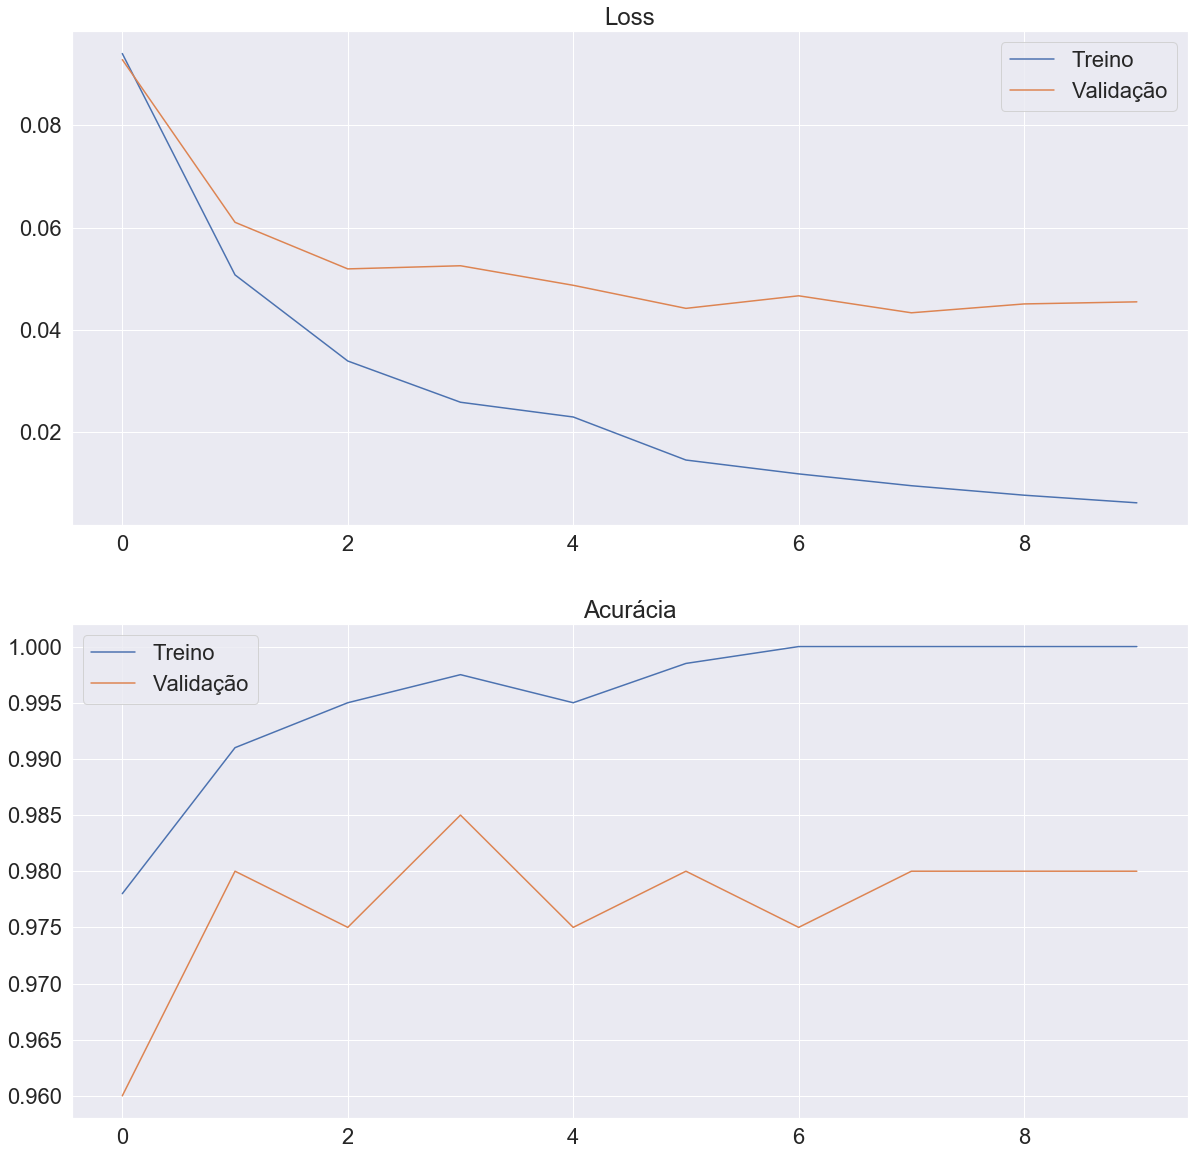

In [18]:
fix, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,20))
x = list(range(len(train['loss'])))
# loss
sns.lineplot(x=x, y=train['loss'], ax=ax1)
sns.lineplot(x=x, y=valid['loss'], ax=ax1)
ax1.set_title('Loss')
ax1.legend(['Treino', 'Validação'])
# acc
sns.lineplot(x=x, y=train['acc'], ax=ax2)
sns.lineplot(x=x, y=valid['acc'], ax=ax2)
ax2.set_title('Acurácia')
ax2.legend(['Treino', 'Validação'])